### Data Overview


In [4]:
# Load libraries
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('reddit_depression_dataset.csv')

# Inspect structure
df.info()
df.head()

# Drop rows with null body
df = df.dropna(subset=['body'])

# Combine title + body
df['text'] = df['title'].fillna('') + ' ' + df['body'].fillna('')

# Drop unneeded columns
df = df[['text', 'upvotes', 'num_comments', 'label']]

# Convert to int
df['upvotes'] = pd.to_numeric(df['upvotes'], errors='coerce').fillna(0).astype(int)
df['num_comments'] = pd.to_numeric(df['num_comments'], errors='coerce').fillna(0).astype(int)

df.head()

/var/folders/pk/gw79fjcj3ms98d64z_qfnmnw0000gn/T/ipykernel_4973/4161313842.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('reddit_depression_dataset.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2470778 entries, 0 to 2470777
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    object 
 1   subreddit     object 
 2   title         object 
 3   body          object 
 4   upvotes       float64
 5   created_utc   float64
 6   num_comments  float64
 7   label         float64
dtypes: float64(4), object(4)
memory usage: 150.8+ MB


,text,upvotes,num_comments,label
0,Deep thoughts underdog Only when we start cons...,4,0,0.0
1,"I like this sub, there's only two posts yet I ...",4,1,0.0
2,Rebirth! Hello. \nI am the new guy in charge h...,6,1,0.0
4,Who am I? You could take any one cell in my bo...,5,4,0.0
5,What is the limit of the knowledge and power a...,8,23,0.0


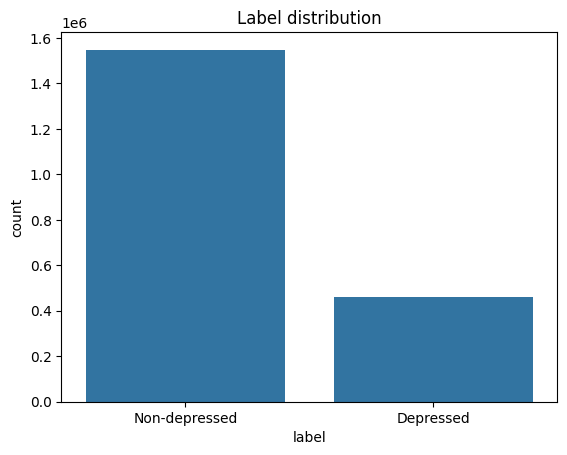

Missing values per column:
 text            0
upvotes         0
num_comments    0
label           0
text_clean      0
dtype: int64


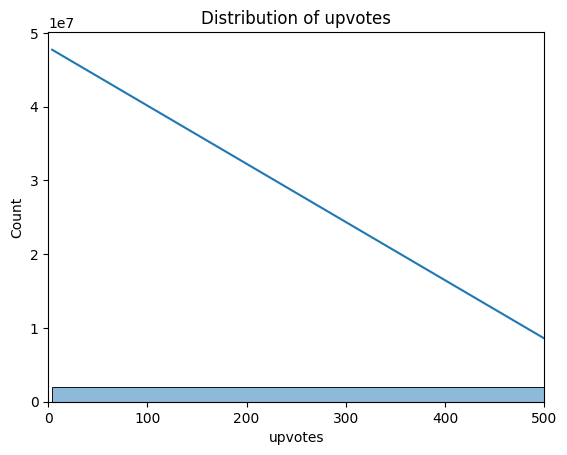

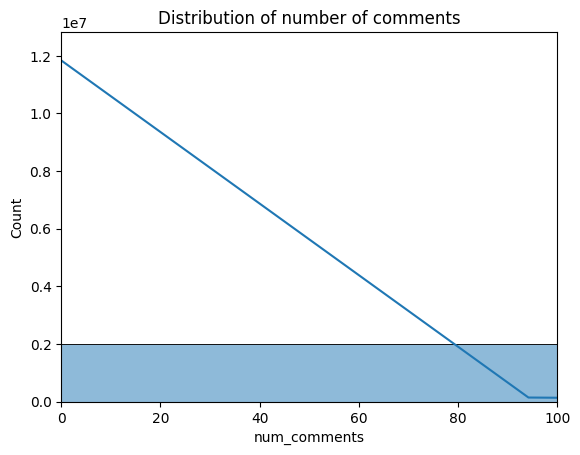

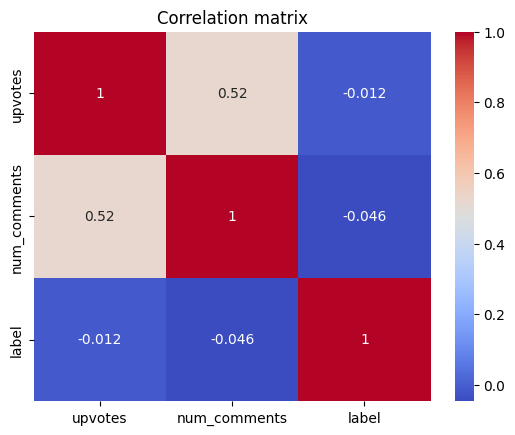

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check label distribution
sns.countplot(x='label', data=df)
plt.title('Label distribution')
plt.xticks([0, 1], ['Non-depressed', 'Depressed'])
plt.show()

# Check missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

# Distribution of upvotes
sns.histplot(df['upvotes'], bins=50, kde=True)
plt.title('Distribution of upvotes')
plt.xlim(0, 500)  # limit x-axis to make the plot readable
plt.show()

# Distribution of number of comments
sns.histplot(df['num_comments'], bins=50, kde=True)
plt.title('Distribution of number of comments')
plt.xlim(0, 100)  # limit x-axis to make the plot readable
plt.show()

# Correlation matrix (numerical features only)
corr = df[['upvotes', 'num_comments', 'label']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

### Baseline Model


In [6]:
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Drop rows with NaNs in either 'label' or 'text'
df = df.dropna(subset=['label', 'text'])

# Convert label column to integers
df['label'] = df['label'].astype(int)

# Text preprocessing function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Clean text
df['text_clean'] = df['text'].apply(clean_text)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df['text_clean'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=30000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train baseline logistic regression
clf = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
clf.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_tfidf)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

Confusion Matrix:
 [[288890  20690]
 [  7311  85038]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9753    0.9332    0.9538    309580
           1     0.8043    0.9208    0.8586     92349

    accuracy                         0.9303    401929
   macro avg     0.8898    0.9270    0.9062    401929
weighted avg     0.9360    0.9303    0.9319    401929



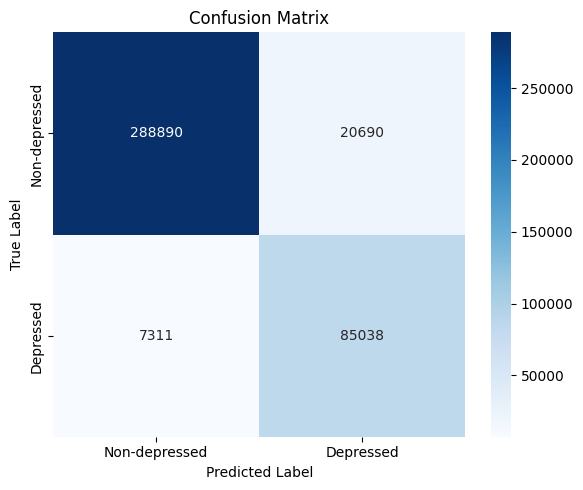

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Non-depressed', 'Depressed'], yticklabels=['Non-depressed', 'Depressed'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Improvement Over Baseline


In [10]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# Convert sparse TF-IDF matrix to DMatrix (XGBoost optimized format)
dtrain = xgb.DMatrix(X_train_tfidf, label=y_train)
dtest = xgb.DMatrix(X_test_tfidf, label=y_test)

# Define parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),  # handle class imbalance
    'eta': 0.1,
    'max_depth': 6,
    'seed': 42
}

# Train XGBoost model
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dtest, 'test')],
    verbose_eval=10
)

# Predict probabilities
y_pred_proba = xgb_model.predict(dtest)

# Threshold to binary prediction
y_pred_xgb = (y_pred_proba >= 0.5).astype(int)

# Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb, digits=4))

[0]	test-logloss:0.64842
[10]	test-logloss:0.44432
[20]	test-logloss:0.37980
[30]	test-logloss:0.34787
[40]	test-logloss:0.32933
[50]	test-logloss:0.31721
[60]	test-logloss:0.30808
[70]	test-logloss:0.30089
[80]	test-logloss:0.29476
[90]	test-logloss:0.28951
[99]	test-logloss:0.28536
Confusion Matrix:
 [[282424  27156]
 [ 13153  79196]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9555    0.9123    0.9334    309580
           1     0.7447    0.8576    0.7971     92349

    accuracy                         0.8997    401929
   macro avg     0.8501    0.8849    0.8653    401929
weighted avg     0.9071    0.8997    0.9021    401929



### Cross-validation & Bias/Variance

In [11]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear'],  # because it works well for sparse data
    'class_weight': ['balanced']
}

# Initialize model
logreg = LogisticRegression(max_iter=1000)

# Setup GridSearchCV
grid_search = GridSearchCV(
    logreg,
    param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='f1',
    verbose=2,
    n_jobs=-1
)

# Run grid search
grid_search.fit(X_train_tfidf, y_train)

# Print best params and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best F1 score on validation set: ", grid_search.best_score_)

# Evaluate on test set using the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_tfidf)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best, digits=4))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; total time=  18.2s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; total time=  18.9s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; total time=  19.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=  26.5s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=  26.6s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=  27.9s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; total time=  52.6s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; total time=  52.7s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; total time=  41.5s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time= 1.0min
[CV] END C=10, class_weight=balanced, penalty=l2, solver=libline

### Final Model Saving & Inference

In [12]:
import joblib

# Save the best model
joblib.dump(best_model, 'logreg_best_model.joblib')
print("Model saved as logreg_best_model.joblib")

# Save the vectorizer too (you need both to make predictions later)
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')
print("Vectorizer saved as tfidf_vectorizer.joblib")

# Example: Load the model and vectorizer
loaded_model = joblib.load('logreg_best_model.joblib')
loaded_vectorizer = joblib.load('tfidf_vectorizer.joblib')

# Example: Predict on new text
example_text = ["I feel very sad and hopeless about everything in my life."]
# Preprocess example text
example_text_clean = [clean_text(example_text[0])]
# Vectorize example text
example_text_tfidf = loaded_vectorizer.transform(example_text_clean)
# Predict
example_pred = loaded_model.predict(example_text_tfidf)
print("Predicted label:", example_pred[0])  # 0 - Non-depressed, 1 - Depressed

Model saved as logreg_best_model.joblib
Vectorizer saved as tfidf_vectorizer.joblib
Predicted label: 1


### Model Saving and Inference Example
- The trained Logistic Regression model was saved as `logreg_best_model.joblib`
- The TF-IDF vectorizer was saved as `tfidf_vectorizer.joblib`
- An example of loading the model and performing inference on new data is provided.